# Math Lectures
### Unit 4 Capstone (Thinkful Data Science)
This notebook examines math lectures on the sentence level. The lectures are vectorized using tf-idf and topics are extracted with Non negative matrix factorization and Latent Dirichlet Allocation.  Here we try to extract topics from AI, Ai10 lecture and Diff eq, Data Structures and Algorithms.

In [195]:
import os
import time
from collections import Counter, OrderedDict
from itertools import islice
import smart_open

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import cluster, ensemble, linear_model, naive_bayes, neighbors, svm
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit


from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')
warnings.filterwarnings("ignore",category=DeprecationWarning)


default_stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
sns.set(style='dark',context='paper',palette='BrBG_r')
%matplotlib inline


 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: \n" % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [2]:
glob_time1 = time.time()

### Importing the data
    - The texts consist of the closed captioning for 93 lectures on varying topics in mathematics, computer science, and engineering
    - The XML files were accessed through the console in a web browser and saved as XML 

In [3]:
#set path to XML files
path = '/root/Desktop/gits/unit-4-NLP-capstone/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([re.sub('.xml','',os.fsdecode(file)) for file in os.listdir(folder)])
\

#Use ElementTree trace xml tree and extract text from xml files, removing tags
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}.xml'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)

In [4]:
#check some text from a random lecture
lecture_texts[47][30:35]

['the most common change of\nvariables is the one simple one',
 'called scaling.\nSo, again, the kind of equation',
 "I'm talking about is a general\nfirst-order equation.",
 'And, scaling simply means to\nchange the coordinates,',
 'in effect, or axes,\nto change the coordinates on']

In [5]:
#create a DataFrame for records
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = [ ' '.join(i) for i in lecture_texts ] #unpack list of lists as string
print(type(raw_data.raw_text[0]))
raw_data.head(1)

<class 'str'>


,filename,raw_text
0,aurouxmcalc1,So let's start right away with\nstuff that we ...


### Cleaning the text

Now we will clean the text removing '\n', the intros (MIT has a long intro), the professor names and other undesirable punctuation etc. Also, we want to replace contractions with thier full counterparts.

In [6]:
#Function to remove identified words through visual inspection
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. ",'',text)
    text = re.sub('Your support will help MIT OpenCourseWare continue to',' ',text)
    text = re.sub(' offer high quality educational resources for free.',' ',text)
    text = re.sub('To make a donation or ',' ',text)
    text = re.sub('view additional materials from hundreds of MIT',' ',text)   
    text = re.sub(' courses, visit MIT OpenCourseWare at ocw.mit.edu.',' ',text)   
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    text = re.sub('Welcome to 6.851 Advanced Data Structures', 'PROFESSOR',text)
    text = re.sub('PROFESSOR: PROFESSOR', ' ',text)
    text = re.sub('PROFESSOR PROFESSOR', ' ',text)
    return text

#list common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


In [7]:
raw_data.raw_text = [ expand_contractions(i) for i in raw_data.raw_text]
raw_data.raw_text = [ text_cleaner(i) for i in raw_data.raw_text]

In [8]:
#label professors
raw_data['Professor'] = ['Auroux']*4 + ['Demaine']*7 + ['Devadas']*9 + ['Jerison']*9 + ['Leighton']*11 + ['Manning']*3 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*18 + ['Winston']* 8
#label_subjects
raw_data['Subject'] = ['Calculus']*4 + ['Data']*7 + ['Algorithms']*9 + ['Calculus']*9 + ['CS Math']*11 + ['NLP']*3\
+ ['Diff. Eq.']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 8 +\
['AI']*8
raw_data.head(5)

,filename,raw_text,Professor,Subject
0,aurouxmcalc1,So let us start right away with stuff that we ...,Auroux,Calculus
1,aurouxmcalc11,to So far we have learned about partial...,Auroux,Calculus
2,aurouxmcalc2,"So , So, yesterday we learned about the questi...",Auroux,Calculus
3,aurouxmcalc5,"to So, so far, we have seen things abou...",Auroux,Calculus
4,demainedata1,. I am . You can call me PROFESSOR. W...,Demaine,Data


### Tokenization with spacy

Here we will parse the text using spacy and append each spacy object (each lecture) to the dataframe.
Then we will create a new data frame with the professor, subject, filename and the spacy doc.
We will use a list comprehension to tokenize each sentences from each lecture and append the list of lists to the dataframe.
Then we will drop the spacy doc, we will -explode- the data frame so that each sentence is an observation, while maintaining tracability to the lecture level.
We will also take the sentence length for further sentence elimination.

In [9]:
#Create Spacy document for each lecture
t1 = time.time()
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]
print('Minutes: {}'.format((time.time()-t1)/60))

Minutes: 4.693093649546305


In [10]:
#more cleaning
def clean_lite (text):
    re.sub("-pron-",'',text)
    return text    

In [11]:
#create a new data frame for the professor,subject and the spacy doc
sentences = raw_data[['filename','Professor','Subject','sdoc']].copy()

#create a list of lists of tokens (remove stop words and punct) 
sentences['sents'] = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in sentences.sdoc]

#convert lecture lists of sentences to lecture string
sentences['text'] = [' '.join([str( ' '.join(i)) for i in j]) for j in sentences.sents]

sentences['text'] = [ ' '.join(pd.Series(sentences.text[i]).str.replace('-pron-',''))\
                     for i in range(len(sentences.text)) ]

In [12]:
#sentences.to_csv('sentences.csv')
sentences.head()

,filename,Professor,Subject,sdoc,sents,text
0,aurouxmcalc1,Auroux,Calculus,"(So, let, us, start, right, away, with, stuff,...","[[so, let, start, right, away, stuff, need, ad...",so let start right away stuff need advanced th...
1,aurouxmcalc11,Auroux,Calculus,"( , to, , So, far, we, have, learned, ab...","[[ , ], [so, far, learn, partial, deriva...",so far learn partial derivative use f...
2,aurouxmcalc2,Auroux,Calculus,"(So, ,, So, ,, yesterday, we, learned, about, ...","[[so, so, yesterday, learn, question, plane, t...",so so yesterday learn question plane think 3x3...
3,aurouxmcalc5,Auroux,Calculus,"( , to, , So, ,, so, far, ,, we, have, s...","[[ , ], [so, far, see, thing, vector, eq...",so far see thing vector equation plan...
4,demainedata1,Demaine,Data,"( , ., I, am, , ., You, can, call, me,...","[[ ], [-pron-, ], [-pron-, professor],...",professor ta tom morgan justin z...


# Breaking the lectures down by sentence.

In an attempt to find out why data structures and algorithms refuse to separate, why an AI lecture consistently jumps to Differential Equations. We will perform some LSA (latent semantic analysis) on the the groups in question, these groups include: Data Structures, Algorithims and the lecture from AI, compared to the rest of AI and compared to differential equations. 

In [15]:
#explode the df to a new df with each sentence on one line
sentences1 = pd.DataFrame({
         col:np.repeat(sentences[col].values, sentences['sents'].str.len())
         for col in sentences.columns.difference(['sents'])
         }).assign(**{'sents':np.concatenate(sentences['sents'].values)})[sentences.columns.tolist()]

#get sentence lengths
sentences1['s_len'] = [len(sent) for sent in sentences1.sents]

In [16]:
#check to make sure distribution of attributes to sentences
sentences1.sample(5,random_state=43)

,filename,Professor,Subject,sdoc,sents,text,s_len
59242,strangmeng5,Strang,Mech. Eng,"( , To, make, a, donation, ,, or, to, , P...","[-pron-, be, get, zero, will]",to donation professor shall start the ...,5
11965,devadasalgos3,Devadas,Algorithms,"( , PROFESSOR, :, So, today, 's, lecture...","[the, reason, interested, algorithm, people, w...",professor so today 's lecture sort wi...,7
5335,demainedata15,Demaine,Data,"( , PROFESSOR, :, All, right, ., Today, ...","[but, general, small, power, 2]",professor all right today go look kind...,5
57511,strangmeng2,Strang,Mech. Eng,"(Your, support, will, help, MIT, OpenCourseWar...","[so, be, differential, equation]",support help mit opencourseware profes...,4
23516,leighton15linearcs,Leighton,CS Math,"( , offer, high, -, quality, educational, res...",[professor],offer high quality educational resource fre...,1


In [17]:
sentences1.shape

(65569, 7)

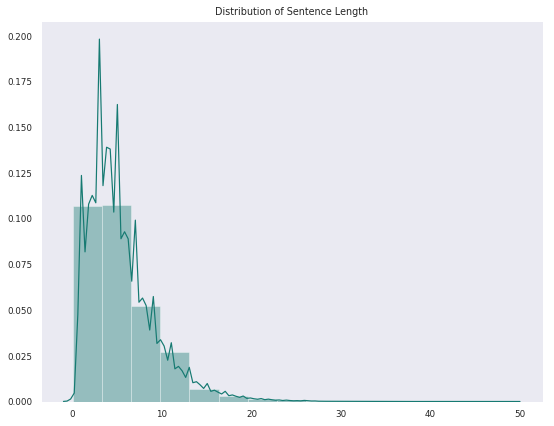

count    65569.000000
mean         5.470649
std          3.800854
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         49.000000
Name: s_len, dtype: float64

In [18]:
plt.figure(figsize=(9,7))
sns.distplot(tuple(sentences1.s_len),bins=15)
plt.title('Distribution of Sentence Length')
plt.show()

sentences1.s_len.describe()

In [19]:
sentences1.shape

(65569, 7)

Currently we have 65000+ sentences that need to be vectorized and processed. In order to avoid complications with the vectorization and clustering, I will set a minimum word length for each sentence.
    
    - Create a list of index numbers to keep
    - Replace the dataframe with only desired index numbers
    - Convert lists of tokens to strings
    - Remove '-pron-' token created by spacy
We've set a window of 9 to 16 sentence size. This will reduce the number of sentences to around 10,000, while hopefully still preserving the substance of the texts.  This is really a compromise. Vectorizing and processing 66,000 sentences is computationally and time intensive, so we want the reduction. Plus, I don't want the model to think sentences like "That's Right" or "Now, what?" or any other short meaningless statement you would hear in a math lecture are more important than longer sentences describing a concept.

In [20]:
#list index numbers to keep
to_keep = [ i for i in sentences1.index if len(sentences1.sents[i]) >= 9 and len(sentences1.sents[i]) <= 16]
#keep index numbers,execute other steps
sentences1 = sentences1.iloc[to_keep]
sentences1['text'] = [' '.join(i) for i in list(sentences1.sents)]
sentences1.text = [ re.sub("-pron-","",sentences1.text[i]) for i in to_keep]
sentences1.reset_index(inplace=True, drop=True) #reset the index here
sentences1.sample(5, random_state=43)

,filename,Professor,Subject,sdoc,sents,text,s_len
3177,leighton14dandcs,Leighton,CS Math,"( , PROFESSOR, :, This, week, we, are, g...","[all, right, like, know, long, till, world, en...",all right like know long till world end t64,9
6641,rigolletstats19,Rigollet,Statistics,"( , to, , PROFESSOR, :, ,, bunch, of, x,...","[think, realization, guy, go, cloud, n, point,...",think realization guy go cloud n point r d.,9
9408,strangmeng6,Strang,Mech. Eng,"( , To, make, a, donation, ,, or, to, , P...","[so, -pron-, want, sum, square, -pron-, think,...",so want sum square think cos(theta sin(theta,9
7650,sochernlp13,Socher,NLP,"( , Network, ,, there, is, actually, a, whole,...","[well, model, go, see, small, norm, feature, v...",well model go see small norm feature vector z ...,11
2590,jerisoncalc21,Jerison,Calculus,"( , To, make, a, donation, ,, or, to, , P...","[and, -pron-, think, order, answer, question, ...",and think order answer question go detail me...,12


In [21]:
sentences1.shape

(10156, 7)

## Extracting topics from select subjects and lectures.
    - We want to perform LSA on the following:
        - All AI lectures, except for the lecture that switches to Differential equations.
        - The AI lecture that switches to Differential Equations
        - Differential Equations lectures as a subject
        - Data Structures
        - Algorithims 

### Tf-Idf Vectorization of the sentences
    Right now we are going to create numerical vectors for each sentence of our given groups using the Tf-idf feature from the genism library.

In [89]:
#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.8, # drop words that occur in more 50% of the sentences
                             min_df=5, # only use words that appear at least 5 times
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True 
                            )

In [240]:
#Isolate each group
AI = sentences1[(sentences1.Subject == 'AI') & (sentences1.filename != 'winstonai10')]['text']
winstonai10 = sentences1[sentences1.filename == 'winstonai10']['text']
diff_eq = sentences1[sentences1.Subject == 'Diff. Eq.']['text']
datas = sentences1[sentences1.Subject == 'Data']['text']
algos = sentences1[sentences1.Subject == 'Algorithms']['text']
mattuck4 = sentences1[sentences1.filename == 'mattuckdifeq4']['text']

groups = [AI, winstonai10, diff_eq, datas, algos]

#Vectorize Each grouping
AI_tfidf  = vectorizer.fit_transform(AI)
winston_tfidf  = vectorizer.fit_transform(winstonai10)
diff_tfidf  = vectorizer.fit_transform(diff_eq)
datas_tfidf  = vectorizer.fit_transform(datas)
algos_tfidf  = vectorizer.fit_transform(algos)
matt4_tfidf  = vectorizer.fit_transform(mattuck4)

In [241]:
AI_tfidf.shape,winston_tfidf.shape, diff_tfidf.shape, datas_tfidf.shape, algos_tfidf.shape, matt4_tfidf.shape

((572, 400), (91, 73), (767, 427), (1101, 512), (864, 464), (104, 72))

Here we are going to calculate the cosine similarity of the sentences in each grouping, then calculate the mean similarity, this will hopefully give us an idea what representetive sentences might be.

In [248]:
ai_sim = pd.DataFrame(cosine_similarity(AI_tfidf), index=AI,
                            columns=AI) # set sentneces as the columns
ai_sim.insert(0, 'mean_similarity', ai_sim.mean(axis=1))


win_sim = pd.DataFrame(cosine_similarity(winston_tfidf), index=winstonai10,
                            columns=winstonai10) # set sentneces as the columns
win_sim.insert(0, 'mean_similarity', win_sim.mean(axis=1))


diff_sim = pd.DataFrame(cosine_similarity(diff_tfidf), index=diff_eq,
                            columns=diff_eq) # set sentneces as the columns
diff_sim.insert(0, 'mean_similarity', diff_sim.mean(axis=1))


data_sim = pd.DataFrame(cosine_similarity(datas_tfidf), index=datas,
                            columns=datas) # set sentneces as the columns
data_sim.insert(0, 'mean_similarity', data_sim.mean(axis=1))



algos_sim = pd.DataFrame(cosine_similarity(algos_tfidf), index=algos,
                            columns=algos) # set sentneces as the columns
algos_sim.insert(0, 'mean_similarity', algos_sim.mean(axis=1))


matt_sim = pd.DataFrame(cosine_similarity(matt4_tfidf), index=mattuck4,
                            columns=mattuck4) # set sentneces as the columns
matt_sim.insert(0, 'mean_similarity', matt_sim.mean(axis=1))

In [249]:
ai_sim[['mean_similarity']].sort_values(by='mean_similarity',ascending=False)[:15]

text,mean_similarity
text,
what want program look like kind smart answer question behavior,0.046144
so way little warm exercise like look integration problem,0.042752
now look connection little detail little piece right sort look like,0.042347
so get example search table like write little flow chart search work,0.041183
so end hour shall able write program like know answer question behavior,0.040889
and write rule like freeze little plastic bag,0.040420
know people come major computer science like write program,0.040179
so get branching type structure look maybe little bit like,0.039813
but know search let speed thing little bit couple search name,0.039805


In [250]:
win_sim[['mean_similarity']].sort_values(by='mean_similarity',ascending=False)[:15]

text,mean_similarity
text,
if look word count want include term computer want use threshold near neighbor,0.085655
and answer question like course want people custodian kind knowledge interested,0.078267
because kind thing computer 's process information like bulldozer process gravel,0.076388
so want guy like better rid dotted x,0.075556
and want idea reappear disguised form area expect,0.075458
and want try simple thing try complex likely understand,0.071154
so lecture learning want spend minute beginning talk lay land,0.070713
very simple calculation head like add number spelling word thing like,0.070142
when think pattern recognition near neighbor base learning get sort mechanism generate vector feature,0.068879


In [251]:
diff_sim[['mean_similarity']].sort_values(by='mean_similarity',ascending=False)[:15]

text,mean_similarity
text,
so equation literature write way k time y prime plus y equal,0.077077
and mean equation form r square plus time r plus squared equal zero,0.074696
the equation z prime x plus z equal z plus minus z.,0.069086
so go equation d square plus omega zero squared apply y equal cosine omega,0.064147
so omega equal omega nought equation look like d square plus omega nought squared natural frequency,0.063902
v prime divide minus n equal p x time v plus q x.,0.062898
and thing plus sine omega nought plus omega time,0.062720
time omega k divide product complex conjugate real number plus omega k square,0.062347
so standard form go look like dtdtd little t plus kt equal k time te,0.062250


In [252]:
data_sim[['mean_similarity']].sort_values(by='mean_similarity',ascending=False)[:15]

text,mean_similarity
text,
so linear time sort log n log log n item,0.076976
but w 2 log n radix 1.1 time log,0.075710
then 2 time log k 2 log k 2,0.075710
if log n log log n item k item sort linear time,0.074379
and w log 2 plus epsilon time log log n.,0.070839
because k time log d minus 1 k pre processing rebuild node,0.068915
tree want identify maximally deep node log n node,0.068418
obviously thing spend log n time search log n array correspond log n subtree,0.067266
so h height tree go like log n minus log log n.,0.066998


In [253]:
algos_sim[['mean_similarity']].sort_values(by='mean_similarity',ascending=False)[:15]

text,mean_similarity
text,
there be operation binary search tree order h time constant time,0.055623
and way sort thing like scheduling sort kind tree include binary tree,0.053985
and time want know sorted order element store nice binary search tree,0.052185
so binary search tree like want know sorted order call order traversal,0.050348
want dive right tell interesting thing like algorithm complexity algorithm,0.050184
that min heap look insert algorithm look require order n time,0.049330
have show binary search tree avl tree order lg n time regular notion time,0.048325
will look different sort algorithm time heap different data structure,0.048191
any time array go look heap representation array picture right tell heap look like,0.046549


In [255]:
matt_sim[['mean_similarity']].sort_values(by='mean_similarity',ascending=False)[:15]

text,mean_similarity
text,
the equation z prime x plus z equal z plus minus z.,0.155294
v prime divide minus n equal p x time v plus q x.,0.151131
so suppose equation let y prime equal y x minus y square,0.137181
so y prime y square equal x time y minus,0.137071
and turn stroke equation z prime x plus z equal f z.,0.130385
x oh like combination plus divide minus y x time,0.118255
so x v prime plus v equal x okay,0.117641
but ultimately way equation solve change linear equation equation variable separable,0.115194
so answer y equal 2x divide x square plus arbitrary constant,0.113632


## Topic Extraction Using NMF and LDA

In [190]:
n_top_words = 20
#Instantiate nmf instance and new tfidf vectorizer
nmf_m = NMF(alpha=0.1, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=400, # when to stop even if the model is not converging (to prevent running forever)
          n_components=10 ,
          random_state=43, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0) 


vectorizer = TfidfVectorizer(max_df=0.95, # drop words that occur in more 50% of the sentences
                             min_df=4, # only use words that appear at least 15
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True 
                            )


In [191]:
def print_nmf (strings):
    tfidf = vectorizer.fit_transform(strings)
    nmf = nmf_m.fit(tfidf)
    tfidf_feature_names = vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)

In [256]:
print('Non Negative Matrix Factorization solver: Coordinate Descent\n\n')
print('\nNMF Topics from Mattuck4\n')
print_nmf(mattuck4)
print('NMF Topics from Winston AI 10\n')
print_nmf(winstonai10)
print('\nNMF Topics from Differential Equations\n')
print_nmf(diff_eq)
print('\nNMF Topics from AI\n')
print_nmf(AI)
print('\nNMF Topics from Data Structures\n')
print_nmf(datas)
print('\nNMF Topics from Algorithms\n')
print_nmf(algos)

Non Negative Matrix Factorization solver: Coordinate Descent



NMF Topics from Mattuck4


Topic #0: 
prime minus plus equal divide write suppose course substitute turn dx equation tangent time like differentiate squared let square right

Topic #1: 
equation solve bernoulli linear kind method homogeneous problem way let differential set turn reason divide mean little answer word like

Topic #2: 
square root log plus squared divide turn suppose equal right let answer time constant tangent hope minus function good equation

Topic #3: 
substitution use direct write inverse equal course problem differentiate instead able try set new variable solve like way look make

Topic #4: 
change variable mean make x1 course new substitute hope answer inverse way divide look unit solve equation let plus substitution

Topic #5: 
angle boat beam 45 slope light function degree tangent word make little want reason let plus like think differential try

Topic #6: 
constant temperature think answer form make

## Use word frequencies with LDA

In [236]:
n_features = 500

lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50,
                                random_state=0)

cvectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

In [237]:
def print_lda (string):
    tf = cvectorizer.fit_transform(string)
    lda.fit(tf)
    print("\nTopics in LDA model:\n")
    tf_feature_names = cvectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)

In [238]:
print("\nLDA Topics in Winston AI 10\n")
print_lda(winstonai10)
print("\nLDA Topics in Differential Equations \n")
print_lda(diff_eq)
print("\nLDA Topics in AI \n")
print_lda(AI)
print("\nLDA Topics in Data Structures \n")
print_lda(datas)
print("\nLDA Topics in Algorithms\n")
print_lda(algos)


LDA Topics in Winston AI 10


Topics in LDA model:


Topic #0: 
talk stuff thing learning near like pattern neighbor word recognition computer straight today base magazine lot town country trajectory position

Topic #1: 
say feature vector come day way worth invent compare recognition happen easy good library value guy decision control world robot

Topic #2: 
area total cover want like concert hole electrical guy custodian attempt come sort include shall measure maximum idea knowledge let

Topic #3: 
stuff velocity acceleration guy want know ball think sleep speed particular trajectory need associate movement value position look talk arm

Topic #4: 
little good variance particular piece movement try 100 record associate want shall just stuff think table easy prime right time

Topic #5: 
perpendicular divide bisector human space article area maximum simple instead use construct boundary line decision thing talk computer want equal

Topic #6: 
10 pitch sleep need want memory try 25 know